In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, root_scalar
import scipy.special as sp
import IGM

r0 = 2.818e-13 # classical electron radius in cm
m_e = 9.10938e-28 # electron mass in gram
c = 2.998e10 # speed of light in cm/s
h = 6.6261e-27 # planck constant in cm^2 g s-1
eV_to_erg = 1.6022e-12
parsec_to_cm = 3.085677581e18 # cm per parsec

kB = 1.3808e-16 # boltzmann constant in cm^2 g s^-2 K^-1
T_CMB = 2.725 # CMB temperature today in K

H_0 = 2.184e-18 # current hubble constant in s^-1
H_r = 3.24076e-18 # 100 km/s/Mpc to 1/s
h_0 = H_0 / H_r
omega_b_0 = 0.0224 / h_0 / h_0  # current baryon abundance
m_p = 1.67262193269e-24 # proton mass in g
G = 6.6743e-8 # gravitational constant in cm^3 g^-1 s^-2
f_He = 0.079 # helium mass fraction
f_H = 0.76 # hydrogen fraction
Y_He = 0.24

E_e = m_e * c * c
rho_crit = 3 * H_0 * H_0 / 8 / np.pi / G
e = 4.80326e-10 # electron charge in esu

z = 2
z2 = (1 + z) / 3
T_CMB *= 1 + z 

T_IGM = 9245.6 # IGM temperature at z = 2 in K

In [2]:
omega_b = omega_b_0 * (1 + z)**3
mean_n_b = 3 * omega_b * H_0 * H_0 / (8 * np.pi * G * m_p) # mean number density of baryons at the redshift
n_b = mean_n_b # for mean density
    
n_H = n_b * (1 - Y_He) # nuclei in hydrogen
n_He = n_H * f_He # nuclei in helium, assume He is all 4He

n_e = n_H + 2 * n_He # for fully ionized

In [3]:
omega_p = c * np.sqrt(4 * np.pi * r0 * n_e)

k = omega_p / c * np.array([1.01, 1.05, 1.1, 1.5, 2]) # wave number
theta_deg = np.array([5, 45, 85])
theta_rad = np.radians(theta_deg)

In [4]:
print(omega_p/c, k[0], theta_rad[0])

4.6007454504527044e-09 4.646752904957231e-09 0.08726646259971647


In [5]:
n = n_e + n_H + n_He

B = np.sqrt(8 * np.pi * kB * T_IGM * n) # equipartion field

omega_c = e * B / (m_e * c)

In [6]:
print(B, omega_c)

1.924794461998326e-08 0.3385322193458688


In [7]:
def dispersion(omega, k, theta_rad):
    res = omega**2 - omega_p**2 / (1 - omega_c**2 / omega**2) - c**2 * k**2 * np.cos(theta_rad)**2 - 1 / (1 - omega_c**2 / omega**2) * omega_c**2 * omega_p**4 / ((omega**2 - c**2 * k**2) * (omega**2 - omega_c**2) - omega_p**2 * omega**2) - c**4 * k**4 * np.sin(theta_rad)**2 * np.cos(theta_rad)**2 / (omega**2 - omega_p**2 - c**2 * k**2 * np.sin(theta_rad)**2)
    return res

In [16]:
# grid has shape (len(k), len(angle)), same row same k, same col same angle
omega = np.zeros((len(k), len(theta_rad)))

for i in range(len(k)):
    for j in range(len(theta_rad)):
        dispersion_fixed = lambda omega: dispersion(omega, k[i], theta_rad[j])
        #initial_guess = omega_p/10
        #omega[i][j] = fsolve(dispersion_fixed, initial_guess)[0]
        omega[i][j] = root_scalar(dispersion_fixed, method='bisect', bracket=[.998*omega_p, 1.002*omega_p]).root

In [18]:
print(omega_p)
print(omega)
print(np.amin(omega)/omega_p, np.amax(omega)/omega_p)

137.9303486045721
[[137.93034867 137.9303527  137.93035673]
 [137.9303489  137.93036792 137.93038693]
 [137.93034915 137.93038466 137.93042016]
 [137.93035036 137.93046401 137.93057765]
 [137.93035097 137.9305044  137.93065782]]
1.0000000004508038 1.0000022418132433


In [19]:
test = np.zeros((len(k), len(theta_rad)))
for i in range(len(k)):
    for j in range(len(theta_rad)):
        test[i][j] = dispersion(omega[i][j], k[i], theta_rad[j])
        
print(np.min(test), np.max(test))

-4.147295840084553e-08 5.388574209064245e-08


In [31]:
def get_eigen(omega, k, theta_rad):
    zeta_x = np.sin(theta_rad) # for now, as zeta will be canceled out later
    zeta_y = 1j * omega_c * omega_p**2 * omega / ((omega**2 - c**2 * k**2) * (omega**2 - omega_c**2) - omega_p**2 * omega**2) * zeta_x
    zeta_z = -c**2 * k**2 * np.sin(theta_rad) * np.cos(theta_rad) / (omega**2 - omega_p**2 - c**2 * k**2 * np.sin(theta_rad)**2) * zeta_x
    return zeta_x, zeta_y, zeta_z

In [34]:
def get_D(i, j):
    omega_ij = omega[i][j]
    zeta_x, zeta_y, zeta_z = get_eigen(omega_ij, k[i], theta_rad[j])
    mag2_zeta = zeta_x**2 + np.abs(zeta_y)**2 + zeta_z**2
    
    add1 = 2 * omega_ij * mag2_zeta
    co1 = omega_p**2 * omega_c**2 / (omega_ij**3 * (1 - omega_c**2 / omega_ij**2)**2)
    co2 = 2 * (zeta_x**2 + np.abs(zeta_y)**2) + 2*zeta_x*zeta_y.imag / omega_c * omega_ij * (1 + omega_c**2 / omega_ij**2)
    return add1 + co1 * co2 # co2 is always xxx + 0j, only real part make sense

In [36]:
D = np.zeros((len(k), len(theta_rad)))
for i in range(len(k)):
    for j in range(len(theta_rad)):
        D[i][j] = get_D(i, j)

In [37]:
print(2*omega_p)
print(D)

275.8606972091442
[[275.86077342 275.86155233 275.86233123]
 [275.86098749 275.86163678 275.86228608]
 [275.8611822  275.86171937 275.86225654]
 [275.86152462 275.86196405 275.86240349]
 [275.86133063 275.86199547 275.8626603 ]]


In [38]:
IGM_00 = IGM.IGM_N(0,0) # mean density
n_CRe = IGM_00.back_Euler() # number density of CRe, shape (399, 399)
E = IGM.E
gamma = E / E_e + 1

In [39]:
np.save('n_CRe.npy', n_CRe)

In [47]:
v = c*np.sqrt(E*(E+2*m_e*c**2))/(E+m_e*c**2) # shape (400, )
p = gamma * m_e * v # shape (400, )
omega_s = omega_c / gamma # shape (400, )

In [109]:
print(IGM_00.z[240], IGM_00.z[120])
n_CRe_z2 = n_CRe[:, 240] # number density of CRe at z = 2, shape (399,)
fCR = n_CRe_z2/(IGM.E_plus-IGM.E_minus)[1:,0]/4./np.pi/p[1:]/(m_e+E[1:]/c**2)
print(np.shape(n_CRe_z2), np.shape(IGM.E_plus), np.shape(fCR))
n_CRe_z2 = np.insert(n_CRe_z2, 0, 0) # insert 0 at beginning for calculation, shape (400, )
fCR = np.insert(fCR, 0, 0) # insert 0 at beginning for calculation, shape (400, )

2.0083681725319145 5.925838073724545
(399,) (400, 1) (399,)


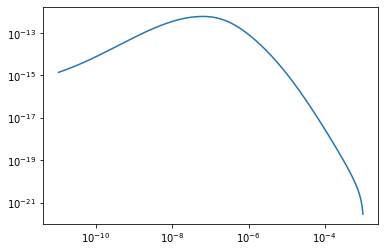

In [110]:
plt.plot(IGM.E[1:], 4.*np.pi*p[1:]**3*np.log(10)*fCR[1:])
plt.yscale('log')
plt.xscale('log')
plt.show()

In [111]:
def get_n_Bessel(omega, k_para, omega_s, v_):
    # cos(alpha) = (omega - n * omega_s) / k_parallel / v
    n_b1 = (omega - k_para * v_) / omega_s
    n_b2 = (omega + k_para * v_) / omega_s
    
    lower_bound = int(min(n_b1, n_b2)) + 1
    upper_bound = int(max(n_b1, n_b2))
    
    #print((omega - n_b1 * omega_s) / k_para / c)
    #print((omega - n_b2 * omega_s) / k_para / c)
    
    return np.array(range(lower_bound, upper_bound + 1))

In [112]:
uu_ = get_n_Bessel(omega[0][0], k[0]*np.cos(theta_rad[0]), omega_s[0], v[0])
print(omega[0][0], k[0]*np.cos(theta_rad[0]), omega_s[0], v[0], uu_[0], uu_[-1])

137.93034866675163 4.629070607260811e-09 0.33852808465897083 148172159.3538325 406 409


In [113]:
def get_Bessel(omega, n_Bessel, omega_s, k_para, k_orth, k, theta_rad, v_):
    cosa = (omega - n_Bessel * omega_s) / k_para / v_
    sina = np.sqrt(1 - cosa**2)
    
    z_Bessel = k_orth * v_ * sina / omega_s
    #print(z_Bessel)
    Jnz = sp.jv(n_Bessel, z_Bessel)
    Jnz_p = sp.jvp(n_Bessel, z_Bessel, n=1)
    
    zeta_x, zeta_y, zeta_z = get_eigen(omega, k, theta_rad)
    
    res_v = n_Bessel / z_Bessel * Jnz * zeta_x * sina + Jnz * zeta_z * cosa + Jnz_p * zeta_y / 1j * sina
    #print(res_v)
    res = res_v.real**2
    #print(res)
    
    return res

In [114]:
get_Bessel(omega[0][0], 407, omega_s[0], k[0]*np.cos(theta_rad[0]), k[0]*np.sin(theta_rad[0]), k[0], theta_rad[0], v[0])

0.0

In [119]:
def get_int(i, j):
    k_para = k[i] * np.cos(theta_rad[j])
    k_orth = k[i] * np.sin(theta_rad[j])
    
    int_sum = 0
    for pi in range(len(p)-1):
        Delta = omega_s[pi] / (np.abs(k_para) * c)
        co1 = p[pi]**2 * (fCR[pi+1] - fCR[pi]) * m_e * c * Delta / omega_s[pi]
        
        n_Bessel = get_n_Bessel(omega[i][j], k_para, omega_s[pi], v[pi])
        if np.size(n_Bessel)>0:
          sum_Bessel = sum(get_Bessel(omega[i][j], ni_Bessel, omega_s[pi], k_para, k_orth, k[i], theta_rad[j], v[pi]) for ni_Bessel in n_Bessel)
          int_sum = int_sum + co1 * sum_Bessel
          print(pi, co1 * sum_Bessel, k[i]*v[pi]/omega[i,j], k_orth*v[pi]/omega_s[pi], n_Bessel.shape, n_Bessel[0], n_Bessel[-1])
        
    return int_sum

In [120]:
def get_damp_rate(i, j):
    res = 2 * np.pi**2 * omega_p**2 * omega[i][j] / (D[i][j] * n_e) * get_int(i,j)
    return res

In [121]:
print(get_damp_rate(2, 0)) # k = 1.1 omega_p/c, theta = 5 degree

0 0.0 0.005436603557105346 0.1930584454276291 (4,) 406 409
1 -0.0 0.005563556971445411 0.19756678384110357 (4,) 406 409
2 -0.0 0.005693474835235818 0.20218040322936148 (4,) 406 409
3 -0.0 0.0058264263620595265 0.20690176226523607 (4,) 406 409
4 -0.0 0.005962482380890632 0.21173337704711173 (4,) 406 409
5 -0.0 0.00610171537375348 0.21667782244068368 (5,) 405 409
6 -0.0 0.006244199514256529 0.22173773345210163 (5,) 405 409
7 -0.0 0.006390010707021165 0.22691580663323654 (6,) 405 410
8 -0.0 0.006539226628026144 0.2322148015198294 (6,) 405 410
9 -0.0 0.0066919267658883804 0.2376375421032851 (6,) 405 410
10 -0.0 0.0068481924641018285 0.24318691833691097 (6,) 405 410
11 -0.0 0.007008106964256222 0.24886588767740328 (6,) 405 410
12 -0.0 0.007171755450258117 0.2546774766624116 (6,) 405 410
13 -0.0 0.007339225093577296 0.26062478252503485 (6,) 405 410
14 -0.0 0.007510605099541712 0.2667109748461079 (6,) 405 410
15 -0.0 0.007685986754705002 0.27293929724517424 (6,) 405 410
16 -0.0 0.007865463475

158 -0.0 0.20582400205897688 7.4403045320392405 (170,) 330 499
159 -0.0 0.21049908229781983 7.615653335198026 (174,) 329 502
160 -0.0 0.2152741479595703 7.795211426264033 (178,) 327 504
161 -0.0 0.22015090258798398 7.979085268426223 (183,) 325 507
162 -0.0 0.22513104748349444 8.167384391216496 (187,) 323 509
163 -0.0 0.23021627901495256 8.360221503059915 (191,) 322 512
164 -0.0 0.23540828572250688 8.557712609310023 (195,) 320 514
165 -0.0 0.24070874520097912 8.759977136092688 (200,) 318 517
166 -0.0 0.24611932075291926 8.967138060302368 (205,) 316 520
167 -0.0 0.25164165780039804 9.179322046116537 (210,) 314 523
168 -0.0 0.2572773800445239 9.396659588417037 (215,) 312 526
169 -0.0 0.26302808536166267 9.619285163531547 (220,) 310 529
170 -0.0 0.268895341425405 9.847337387734353 (225,) 308 532
171 -0.0 0.27488068104348307 10.080959183973308 (231,) 306 536
172 -0.0 0.28098559719908583 10.320297957319015 (236,) 304 539
173 -0.0 0.2872115377863795 10.565505779663265 (241,) 302 542
174 -0.0 

276 -7.908296915277294e-20 1.079269402064841 198.34308089860463 (4533,) -157 4375
277 -6.999675563442976e-20 1.080777196131627 206.1914845149185 (4712,) -166 4545
278 -6.18589724007354e-20 1.0821860145848992 214.3996438010878 (4900,) -176 4723
279 -5.463614007789765e-20 1.0835012176315808 222.98482798992526 (5097,) -186 4910
280 -4.82149051347464e-20 1.0847279933953375 231.96512277357067 (5301,) -196 5104
281 -4.2491712876941606e-20 1.0858713507447537 241.3594683782393 (5517,) -207 5309
282 -3.743391122646628e-20 1.0869361138173248 251.1876994572614 (5741,) -218 5522
283 -3.2932058955575873e-20 1.0879269181219586 261.47058688982605 (5977,) -230 5746
284 -2.8943573386953495e-20 1.0888482080982462 272.2298815767513 (6222,) -241 5980
285 -2.542768657260689e-20 1.0897042360084241 283.4883603286895 (6480,) -254 6225
286 -2.230211037024523e-20 1.0904990620374877 295.2698739464661 (6749,) -267 6481
287 -1.9548152518244472e-20 1.0912365554781323 307.59939759775415 (7031,) -280 6750
288 -1.7121

373 -1.3292739759063472e-26 1.0999959506610881 14403.596842601555 (329267,) -14393 314873
374 -1.1007155205912325e-26 1.0999963065240512 15082.3175832761 (344782,) -15071 329710
375 -9.10362879911061e-27 1.0999966311163931 15793.107260447841 (361031,) -15782 345248
376 -7.5242953744827e-27 1.0999969271811734 16537.481122354355 (378048,) -16526 361521
377 -6.215838021322677e-27 1.0999971972214433 17317.02601138467 (395868,) -17305 378562
378 -5.127905118356801e-27 1.0999974435211715 18133.403746880005 (414531,) -18121 396409
379 -4.2284169451549356e-27 1.099997668164346 18988.35466776892 (434075,) -18975 415099
380 -3.481033390854298e-27 1.0999978730524267 19883.701342589342 (454543,) -19870 434672
381 -2.862533705075401e-27 1.0999980599202792 20821.352454806176 (475977,) -20807 455169
382 -2.3515370463053767e-27 1.0999982303507236 21803.306871706987 (498424,) -21788 476635
383 -1.927860794247345e-27 1.099998385787822 22831.657905549982 (521933,) -22816 499116
384 -1.578736035976339e-27

In [122]:
print(get_damp_rate(2, 2)) # k = 1.1 omega_p/c, theta = 85 degree

39 -0.0 0.013374722644652509 5.429016559833353 (1,) 407 407
40 -0.0 0.013687013944274278 5.555800061654205 (1,) 407 407
41 -0.0 0.014006595314427854 5.685544565646607 (1,) 407 407
42 -0.0 0.014333636808891062 5.818319242215819 (1,) 407 407
43 -0.0 0.014668312439334837 5.954194878826141 (1,) 407 407
44 -0.0 0.01501080026680126 6.09324391789075 (2,) 407 408
45 -0.0 0.015361282495250183 6.2355404955556315 (2,) 407 408
46 -0.0 0.015719945567217473 6.381160481398949 (2,) 407 408
47 -0.0 0.016086980261629132 6.530181519068055 (2,) 407 408
48 -0.0 0.016462581793816402 6.682683067876852 (2,) 407 408
49 -0.0 0.01684694991777667 6.838746445386558 (2,) 407 408
50 -0.0 0.01724028903072671 6.998454870993892 (2,) 407 408
51 -0.0 0.017642808279994728 7.16189351055104 (2,) 407 408
52 -0.0 0.018054721672298324 7.3291495220424485 (2,) 407 408
53 -0.0 0.018476248185456793 7.500312102344433 (2,) 407 408
54 -0.0 0.018907611882585374 7.675472535093685 (2,) 407 408
55 -0.0 0.019349042028820825 7.854724239692

246 -2.654262636418717e-25 0.9595353324425825 796.508617506557 (139,) 764 902
247 -5.675378201148887e-24 0.9665342413285237 821.691390931954 (144,) 782 925
248 -9.139848734360143e-23 0.9733037326211158 847.8768710236293 (148,) 801 948
249 -1.0927260196320416e-21 0.9798427729256974 875.1127670281702 (154,) 820 973
250 -9.530421065160441e-21 0.986150957399467 903.4491798325612 (158,) 841 998
251 -5.909306650964884e-20 0.9922284973581956 932.9387155925938 (163,) 863 1025
252 -2.507016894029206e-19 0.9980762039261911 963.6366042843596 (169,) 885 1053
253 -6.887303587642949e-19 1.0036954679719976 995.6008234011035 (174,) 909 1082
254 -1.1235045736189257e-18 1.0090882366138345 1028.8922270314365 (180,) 934 1113
255 -9.795320223498547e-19 1.0142569866147089 1063.5746805694198 (186,) 960 1145
256 -6.1626711787968255e-19 1.0192046950168987 1099.715201322374 (193,) 987 1179
257 -7.501646511089662e-19 1.0239348073887213 1137.3841052983973 (199,) 1016 1214
258 -6.137355669748183e-19 1.028451204072

346 -1.8240961557652188e-24 1.0999511443017371 47649.384728419886 (8337,) 39317 47653
347 -1.524727923304728e-24 1.0999553658655068 49879.886853798824 (8728,) 41157 49884
348 -1.2775121624965615e-24 1.0999592198518664 52215.77032791605 (9137,) 43084 52220
349 -1.0620327897203154e-24 1.0999627380722168 54662.01473419821 (9565,) 45102 54666
350 -9.026347287676588e-25 1.099965949609735 57223.834922319635 (10013,) 47216 57228
351 -7.466817633949088e-25 1.0999688810501789 59906.6921250498 (10482,) 49430 59911
352 -6.256962151856262e-25 1.0999715566935697 62716.30560034202 (10974,) 51748 62721
353 -5.2446813491687655e-25 1.0999739987482846 65658.66482348122 (11489,) 54175 65663
354 -4.408796834115862e-25 1.0999762275089817 68740.04225528083 (12027,) 56718 68744
355 -3.6647730172001167e-25 1.09997826151966 71967.00671354745 (12593,) 59380 71972
356 -3.0766129709349135e-25 1.0999801177230606 75346.43737631894 (13184,) 62168 75351
357 -2.5341212529648046e-25 1.099981811597528 78885.53844672668 

### ignore the following part, didn't finish running

In [23]:
import time

damp_rate = np.zeros((len(k), len(theta_rad)))
time_start = time.time()
for j in range(len(theta_rad)):
    for i in range(len(k)):
        print(f'i = {i}, j = {j}, {(time.time() - time_start)/60}')
        damp_rate[i][j] = get_damp_rate(i, j)
        np.save('damp_rate.npy', damp_rate)

i = 0, j = 0, 4.267692565917968e-06
0 (820,)
1 (820,)
2 (820,)
3 (820,)
4 (820,)
5 (820,)
6 (820,)
7 (820,)
8 (820,)
9 (820,)
10 (820,)
11 (820,)
12 (820,)
13 (820,)
14 (820,)
15 (820,)
16 (820,)
17 (820,)
18 (820,)
19 (820,)
20 (820,)
21 (820,)
22 (820,)
23 (820,)
24 (820,)
25 (820,)
26 (820,)
27 (820,)
28 (820,)
29 (820,)
30 (820,)
31 (820,)
32 (820,)
33 (820,)
34 (820,)
35 (820,)
36 (820,)
37 (820,)
38 (820,)
39 (820,)
40 (820,)
41 (820,)
42 (820,)
43 (820,)
44 (820,)
45 (820,)
46 (820,)
47 (820,)
48 (820,)
49 (820,)
50 (820,)
51 (820,)
52 (820,)
53 (820,)
54 (820,)
55 (820,)
56 (820,)
57 (820,)
58 (820,)
59 (820,)
60 (820,)
61 (820,)
62 (821,)
63 (821,)
64 (821,)
65 (821,)
66 (821,)
67 (821,)
68 (821,)
69 (821,)
70 (821,)
71 (821,)
72 (821,)
73 (821,)
74 (821,)
75 (821,)
76 (821,)
77 (821,)
78 (821,)
79 (821,)
80 (821,)
81 (821,)
82 (821,)
83 (821,)
84 (821,)
85 (820,)
86 (820,)
87 (820,)
88 (820,)
89 (820,)
90 (820,)
91 (820,)
92 (820,)
93 (820,)
94 (820,)
95 (820,)
96 (820,)
97 (

KeyboardInterrupt: 

In [24]:
#same row same k, same col same theta
#k = omega_p / c * np.array([1.01, 1.05, 1.1, 1.5, 2]) # wave number
#theta_deg = np.array([5, 45, 85])
#theta_rad = np.radians(theta_deg)

print(damp_rate)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.21502162e-73  0.00000000e+00  0.00000000e+00]]
